# Import

In [3]:
# ======================================================
# 주가 데이터 
import FinanceDataReader as fdr
import pandas_datareader.data as pdr

# ======================================================
# TA-Lib
# import talib

# ======================================================
# basic library
import warnings

import openpyxl
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import time
import math
import os
import os.path
import random
import shutil
import glob

# ======================================================
# tqdm
from tqdm import tqdm

# ======================================================
# datetime
from datetime import timedelta, datetime

# ======================================================
# plotting library
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.subplots as ms
import plotly.express as px

import mplfinance as fplt
from mplfinance.original_flavor import candlestick2_ohlc, volume_overlay

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import MonthLocator
from PIL import Image

import seaborn as sns
import cv2
import csv

# plt.rcParams['figure.dpi'] = 150
from IPython.display import clear_output

# 종목 파라미터

In [2]:
kospi = pd.read_excel("./2022년_마지막거래일기준_시총.xlsx") # 2022년도 마지막 거래일 기준

c:\Users\coden\anaconda3\envs\capstone\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
# 이미지 생성용 파라미터
seq_len = 10 # 5일당 1주
window_len = int(seq_len/2)

kospi_tickers = kospi.sort_values("시가총액", ascending=False).iloc[:150, :]# 시총 상위 100개만 활용

train_start_day = '2013-01-01'
train_end_day = '2021-01-07' 

test_start_day = '2021-01-01'
test_end_day = '2022-12-31'

threshold = 8

# 전 종목 방향 예측 정확도 계산

In [137]:
folder_path = './img_without_vol_10/train/' # 폴더 경로 설정
folder_names = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]

In [138]:
folder_path = './img_without_vol_10/train/'

for folder_name in os.listdir(folder_path):
    folder = os.path.join(folder_path, folder_name)
    if os.path.isdir(folder):
        num_images = len(os.listdir(folder))
        # print(f"{folder_name}: {num_images} images")

In [139]:
folder_path = './img_without_vol_10/train/'
folders = {}
for folder in os.listdir(folder_path):
    folder_dir = os.path.join(folder_path, folder)
    if os.path.isdir(folder_dir):
        num_images = len(os.listdir(folder_dir))
        folders[folder] = num_images
        
folder_names = [folder for folder, num_images in folders.items() if num_images > 390]

In [140]:
len(folder_names)

120

In [141]:
# ticker와 accuracy 값을 저장하는 데이터프레임 생성
accuracy_df = pd.DataFrame(columns=['ticker', 'accuracy'])

# 각 종목의 데이터를 가져와서 종목 별로 이미지를 생성하여 기간 별로 저장 (Train)
for ticker in tqdm(folder_names):
    with open(f'./img_without_vol_10/train_moving/{ticker}_moving_label.txt', 'r') as f:
        lines = f.readlines()

    labels = {}

    for line in lines:
        path, direction = line.strip().split(',')
        label = path.split('/')[-1]
        if direction == 'Up':
            labels[label] = 1
        elif direction == 'Down':
            labels[label] = 0
    
    test_dir = f'./img_without_vol_10/test/{ticker}/'
    results = []
    for folder_name in os.listdir(test_dir):
        folder_path = os.path.join(test_dir, folder_name)
        if os.path.isdir(folder_path):
            up_count = 0
            down_count = 0
            for image_file in os.listdir(folder_path):
                if image_file.endswith('.png'):
                    image_name = image_file.split('.')[0]
                    if image_name in labels:
                        if labels[image_name] == 1:
                            up_count += 1
                        elif labels[image_name] == 0:
                            down_count += 1
            results.append((folder_name, up_count, down_count))

    train_df = pd.DataFrame(results, columns=['stock_frame', 'Up', 'Down'])

    # stock_frame 열에서 '_뒤'의 숫자 값을 추출하여 정수형으로 저장
    train_df['num'] = train_df['stock_frame'].str.split('_').str.get(1).astype(int)

    # '_뒤'의 숫자 값을 기준으로 오름차순 정렬
    train_df = train_df.sort_values(by='num')

    # 정렬 후 필요 없어진 열 삭제
    train_df = train_df.drop('num', axis=1).reset_index().drop('index', axis=1)

    train_df['position'] = ''

    for i in range(len(train_df)):
        if train_df['Up'][i] >= threshold:
            train_df['position'][i] = 1
        
        elif train_df['Down'][i] >= threshold:
            train_df['position'][i] = 0
        
        else:
            train_df['position'][i] = None
    
    # 파일 경로와 이름
    filename = f'./img_without_vol_10/test_moving/{ticker}_moving_label.txt'

    # 파일 열기
    with open(filename, 'r') as f:
        file_list = f.read().splitlines()

    # 데이터프레임으로 변환
    test_df = pd.DataFrame([x.split(',') for x in file_list], columns=['filename', 'direction'])
    test_df['stock_frame'] = test_df['filename'].str.split('/').str[4]
    test_df['stock_frame'] = test_df['stock_frame'].str.replace('_moving', '')
    test_df.drop(columns=['filename'], inplace=True)
    
    test_df['real_position'] = ''
    for i in range(len(test_df)):
        if test_df['direction'][i] == "Up":
            test_df['real_position'][i] = 1
        else:
            test_df['real_position'][i] = 0
    
    final_df = pd.merge(train_df[['stock_frame', 'position']], test_df[['stock_frame', 'real_position']], on = 'stock_frame', how = 'inner')
    # None 값이 있는 행 제거
    final_df.dropna(inplace=True)
    accuracy = (final_df['position'] == final_df['real_position']).mean()
    
    # 정확도 계산 후 accuracy_df에 추가
    accuracy_df = accuracy_df.append({'ticker': ticker, 'accuracy': accuracy}, ignore_index=True)
    # print(f'정확도: {accuracy:.2%}')

  0%|          | 0/120 [00:00<?, ?it/s]c:\Users\coden\anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\coden\anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\coden\anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 12

In [142]:
accuracy_df = accuracy_df.sort_values('accuracy', ascending = False).reset_index(drop=True)

In [143]:
if not os.path.exists(f'./result/'):
                os.makedirs(f'./result/')

accuracy_df.to_csv(f'./result/accuracy-{threshold}.csv', header = True, encoding='euc-kr')

In [144]:
accuracy_df['accuracy'].mean()

0.5003829758088846

In [145]:
# ticker_list = list(accuracy_df[accuracy_df['accuracy'] >= 0.5]['ticker'].astype(str))

# 매매 백테스팅 수익률 확인하기

In [146]:
folder_path = './img_without_vol_10/train/'
folders = {}
for folder in os.listdir(folder_path):
    folder_dir = os.path.join(folder_path, folder)
    if os.path.isdir(folder_dir):
        num_images = len(os.listdir(folder_dir))
        folders[folder] = num_images
        
folder_names = [folder for folder, num_images in folders.items() if num_images > 390]

In [148]:
if not os.path.exists(f'./meme/trade_{threshold}'):
                os.makedirs(f'./meme/trade_{threshold}')

In [149]:
# Create an empty DataFrame to store the results
results_bench_df = pd.DataFrame(columns=['ticker', 'Profit Rate(%)'])
results_candle_df = pd.DataFrame(columns=['ticker', 'Profit Rate(%)'])

# 각 종목의 데이터를 가져와서 종목 별로 이미지를 기간 별로 저장 (Train)
for ticker in tqdm(folder_names):
    with open(f'./img_without_vol_10/train_moving/{ticker}_moving_label.txt', 'r') as f:
        lines = f.readlines()

    labels = {}

    for line in lines:
        path, direction = line.strip().split(',')
        label = path.split('/')[-1]
        if direction == 'Up':
            labels[label] = 1
        elif direction == 'Down':
            labels[label] = 0
    
    test_dir = f'./img_without_vol_10/test/{ticker}/'
    results = []
    for folder_name in os.listdir(test_dir):
        folder_path = os.path.join(test_dir, folder_name)
        if os.path.isdir(folder_path):
            up_count = 0
            down_count = 0
            for image_file in os.listdir(folder_path):
                if image_file.endswith('.png'):
                    image_name = image_file.split('.')[0]
                    if image_name in labels:
                        if labels[image_name] == 1:
                            up_count += 1
                        elif labels[image_name] == 0:
                            down_count += 1
            results.append((folder_name, up_count, down_count))

    train_df = pd.DataFrame(results, columns=['stock_frame', 'Up', 'Down'])

    # stock_frame 열에서 '_뒤'의 숫자 값을 추출하여 정수형으로 저장
    train_df['num'] = train_df['stock_frame'].str.split('_').str.get(1).astype(int)

    # '_뒤'의 숫자 값을 기준으로 오름차순 정렬
    train_df = train_df.sort_values(by='num')

    # 정렬 후 필요 없어진 열 삭제
    train_df = train_df.drop('num', axis=1).reset_index().drop('index', axis=1)

    train_df['position'] = ''

    for i in range(len(train_df)):
        if train_df['Up'][i] >= threshold:
            train_df['position'][i] = 1
        
        elif train_df['Down'][i] >= threshold:
            train_df['position'][i] = 0
        
        else:
            train_df['position'][i] = None
            
    # ==========================================================================================
    ##### 종목 별로 매수, 매도 시그널 생성 부분 #####
    stock_data = pd.DataFrame(fdr.DataReader(ticker, test_start_day, test_end_day))
    stock_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)
    stock_data = stock_data.reset_index()
    # ==========================================================================================
    
    # '매매 신호' 데이터 프레임에서 position 열의 값을 추출합니다.
    positions = list(train_df['position'])

    # 데이터 프레임의 10번째 행부터 5행 단위로 position 열 값을 채웁니다.
    for i in range(10, len(stock_data), 5):
        stock_data.loc[i, 'position'] = positions[(i-10)//5]
        
    stock_data = stock_data.dropna(subset=['position']).reset_index(drop=True)
    stock_data['position'] = stock_data['position'].astype(int)
    
    # Open열의 0값을 해당 행의 Close열 값으로 대체
    stock_data.loc[stock_data['Open'] == 0, 'Open'] = stock_data['Close']
    # ==========================================================================================
    ##### 벤치 마크 수익률 Buy and Hold #####
    # 첫 행과 마지막 행의 Open과 Close 값을 가져옴
    start_price = stock_data.loc[0, 'Open']
    end_price = stock_data.loc[len(stock_data) - 1, 'Open']

    # 수익률 계산
    profit_rate = (end_price - start_price) / start_price * 100
    results_bench_df = results_bench_df.append({'ticker': ticker, 'Profit Rate(%)': profit_rate}, ignore_index=True)
    
    # ==========================================================================================
    # 시작 전 기본설정된 매매 신호는 'No action'이라고 가정합니다.
    action = "No action"

    # position 값을 사용해 action 값을 설정하고 컬럼으로 추가합니다.
    for i in range(len(stock_data)):
        # 이전 행의 position 값
        if i == 0:
            prev_pos = 0  # 첫 번째 행에서는 이전 행이 없으므로 0으로 설정합니다.
        else:
            prev_pos = stock_data.loc[i-1, 'position']
        # 현재 행의 position 값
        curr_pos = stock_data.loc[i, 'position']
    
        # 첫 번째 행에서 position 값에 따라 action 값을 결정합니다.
        if i == 0:
            if curr_pos == 0:
                action = "No action"
            else:
                action = "매수"
        # 이전 행에서 매수한 경우
        elif prev_pos == 1:
            # 현재 행에서도 매수를 유지하는 경우
            if curr_pos == 1:
                action = "홀딩"
            # 현재 행에서 매도를 하는 경우
            else:
                action = "매도"
        # 이전 행에서 매도를 한 경우 또는 'No action'을 한 경우
        else:
            # 현재 행에서 매도를 한 경우 또는 'No action'을 한 경우
            if curr_pos == 0:
                action = "No action"
            # 현재 행에서 매수를 하는 경우
            else:
                action = "매수"
    
        if i == len(stock_data) - 1:
            action = "매도"
        # action 값을 컬럼으로 추가합니다.
        stock_data.loc[i, 'action'] = action
        
    df_buy_sell = stock_data[stock_data['action'].isin(['매수', '매도'])].reset_index(drop=True)

    # ==========================================================================================
    ##### 제안 매매법 수익률 Candle meme #####
    buy_dates = []
    buy_prices = []
    return_rates = []  # 각 매도 별 수익률 저장 리스트

    # 누적 수익률을 계산할 변수 초기화
    total_return = 1

    # 데이터 프레임에 누적 수익률, 매수 가격, 매도 가격, 실현 수익 컬럼 추가
    df_buy_sell['Accumulated Return'] = None
    df_buy_sell['Return Rate'] = None
    df_buy_sell['Buy Price'] = None
    df_buy_sell['Sell Price'] = None
    df_buy_sell['Realized Return'] = None

    # 첫 행부터 끝까지 반복
    for i in range(len(df_buy_sell)):

        # 현재 행의 action이 매수인 경우
        if df_buy_sell.loc[i, 'action'] == '매수':
        
            # 매수한 날짜와 가격을 리스트에 추가
            buy_dates.append(df_buy_sell.loc[i, 'Date'])
            buy_prices.append(df_buy_sell.loc[i, 'Open'])
        
        # 현재 행의 action이 매도인 경우
        elif df_buy_sell.loc[i, 'action'] == '매도':
        
            # 이전에 매수한 가격이 없다면 continue
            if len(buy_prices) == 0:
                continue
        
            # 이전에 매수한 가격이 있다면 가장 최근의 가격으로 매도
            sell_price = df_buy_sell.loc[i, 'Close']
            buy_price = buy_prices.pop()
        
            # 수익률 계산 및 누적 수익률에 반영
            return_rate = sell_price / buy_price
            total_return *= return_rate
        
            # 누적 수익률, 매수 가격, 매도 가격, 실현 수익을 데이터프레임에 반영
            df_buy_sell.loc[i, 'Accumulated Return'] = round((total_return - 1) * 100, 2)
            df_buy_sell.loc[i, 'Return Rate'] = round((return_rate - 1) * 100, 2)
            df_buy_sell.loc[i, 'Buy Price'] = buy_price
            df_buy_sell.loc[i, 'Sell Price'] = sell_price
            df_buy_sell.loc[i, 'Realized Return'] = sell_price - buy_price
            return_rates.append(round((return_rate - 1) * 100, 2))      
    results_candle_df = results_candle_df.append({'ticker': ticker, 'Profit Rate(%)': round((total_return - 1) * 100, 2)}, ignore_index=True)
    
    ############### 개별 종목 매매 내역 성과 부분 ###############
    stock_data.to_csv(f'./meme/trade_{threshold}/{ticker}.csv', header = True, encoding='euc-kr') 
    df_buy_sell.to_csv(f'./meme/trade_{threshold}/{ticker}_buy_sell.csv', header = True, encoding='euc-kr')
    ############### 개별 종목 매매 누적수익 성과 부분 ###############
    results_bench_df.to_csv(f'./result/benchmark_result.csv', header = True, encoding='euc-kr') 
    results_candle_df.to_csv(f'./result/candle_meme_result.csv', header = True, encoding='euc-kr')
    #################################################################

  0%|          | 0/120 [00:00<?, ?it/s]c:\Users\coden\anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\coden\anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\coden\anaconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 12

In [132]:
results_bench_df.sort_values('Profit Rate(%)', ascending = False).reset_index(drop=True)

,ticker,Profit Rate(%)
0,004690,358.737864
1,017390,355.752212
2,138040,328.280773
3,016710,293.053016
4,000060,225.503356
...,...,...
115,068270,-45.867648
116,018880,-52.601156
117,036570,-54.010695
118,008930,-54.387642


In [133]:
results_candle_df.sort_values('Profit Rate(%)', ascending = False).reset_index(drop=True)

,ticker,Profit Rate(%)
0,138040,594.52
1,005070,289.63
2,017390,175.42
3,004690,156.28
4,047810,138.57
...,...,...
115,096770,-41.27
116,034220,-41.64
117,004020,-43.38
118,035420,-48.05


# 캔들 스틱 매매법 수익률 확인하기

In [134]:
results_bench_df['Profit Rate(%)'].mean()

10.114923596801498

In [135]:
results_candle_df['Profit Rate(%)'].mean()

13.710916666666666

In [106]:
profit_rate_std_bench = results_bench_df['Profit Rate(%)'].std()
profit_rate_std_candle = results_candle_df['Profit Rate(%)'].std()

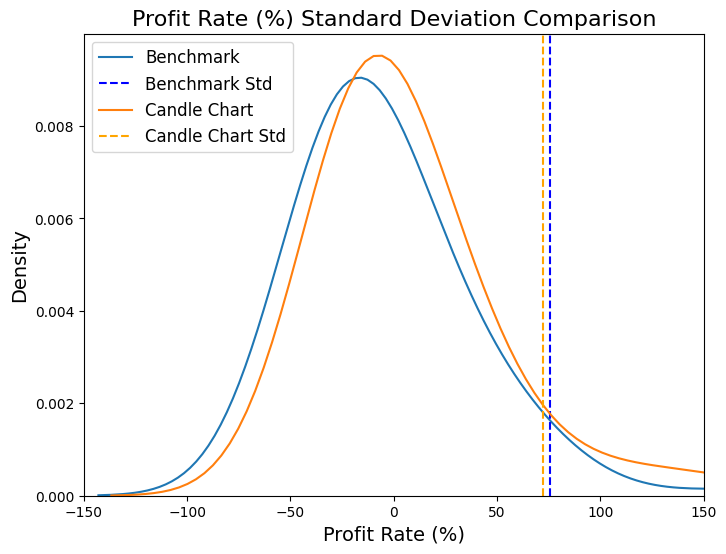

In [107]:
# 그래프 크기 설정
plt.figure(figsize=(8,6))

# 벤치마크 데이터프레임의 Profit Rate(%) 표준편차를 시각화
sns.kdeplot(data=results_bench_df['Profit Rate(%)'], label='Benchmark')
plt.axvline(profit_rate_std_bench, color='blue', linestyle='--', label='Benchmark Std')

# 캔들차트 데이터프레임의 Profit Rate(%) 표준편차를 시각화
sns.kdeplot(data=results_candle_df['Profit Rate(%)'], label='Candle Chart')
plt.axvline(profit_rate_std_candle, color='orange', linestyle='--', label='Candle Chart Std')

# 그래프 타이틀, 라벨, 범례 등 설정
plt.title('Profit Rate (%) Standard Deviation Comparison', fontsize=16)

plt.xlim([-150, 150])

plt.xlabel('Profit Rate (%)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(fontsize=12)
plt.show()

# 포트폴리오 비교

In [159]:
stock_trade = pd.read_csv(f"./meme/trade_8/000880_buy_sell.csv", encoding='euc-kr')
stock_trade = stock_trade.dropna(axis = 0)
stock_trade = stock_trade[['Return Rate', 'Accumulated Return', 'Buy Price', 'Sell Price', 'Realized Return']]

In [160]:
stock_trade.head()

,Return Rate,Accumulated Return,Buy Price,Sell Price,Realized Return
1,-4.22,-4.22,34350.0,32900.0,-1450.0
3,-5.19,-9.19,30850.0,29250.0,-1600.0
5,3.67,-5.85,28600.0,29650.0,1050.0
7,5.98,-0.22,29250.0,31000.0,1750.0
9,-1.86,-2.08,32200.0,31600.0,-600.0


In [168]:
trade_result = pd.DataFrame(columns=['ticker', 'No_trade','Winning_ratio','profit_average', 'loss_average', 'payoff_ratio', 'profit_factor'])

for ticker in tqdm(folder_names):
    stock_trade = pd.read_csv(f"./meme/trade_8/{ticker}_buy_sell.csv", encoding='euc-kr')
    stock_trade = stock_trade.dropna(axis = 0)
    stock_trade = stock_trade[['Return Rate', 'Accumulated Return', 'Buy Price', 'Sell Price', 'Realized Return']]
    
    # 이익을 낸 거래 수와 총 거래 수 계산
    profitable_trades = len(stock_trade[stock_trade['Realized Return'] > 0])
    total_trades = len(stock_trade)

    # 승률 계산
    win_rate = profitable_trades / total_trades * 100
    
    # 수익 계산
    positive_profit = stock_trade[stock_trade['Realized Return'] > 0]['Realized Return']
    profit_average = positive_profit.mean() # 평균 수익금액 -> 아웃풋
    profit_sum = positive_profit.sum() # 총 수익금액
     
    # 손실 계산
    negative_profit = stock_trade[stock_trade['Realized Return'] < 0]['Realized Return'] * -1
    loss_average = negative_profit.mean() # 평균 손실금액 -> 아웃풋
    loss_sum = negative_profit.sum() # 총 손실금액
    
    # payoff_ratio
    payoff_ratio = profit_average / loss_average # -> 아웃풋
    
    # profit_factor
    profit_factor = profit_sum / loss_sum # -> 아웃풋
    
    trade_result = trade_result.append({'ticker': ticker, 'No_trade': total_trades, 'Winning_ratio':win_rate,
                                        'profit_average': profit_average, 'loss_average': loss_average,
                                        'payoff_ratio': payoff_ratio, 'profit_factor': profit_factor}, ignore_index=True)
    

100%|██████████| 120/120 [00:00<00:00, 145.67it/s]


In [176]:
trade_result.to_csv("final_result.csv", encoding='euc-kr')

In [180]:
print("Payoff-Ratio:", trade_result['payoff_ratio'].mean())

Payoff-Ratio: 1.093921529228356


In [179]:
print("profit_factor:", trade_result['profit_factor'].mean())

profit_factor: 1.3403977087357317


In [181]:
trade_result

,ticker,No_trade,Winning_ratio,profit_average,loss_average,payoff_ratio,profit_factor
0,000060,21,42.857143,1761.111111,2845.833333,0.618838,0.464129
1,000080,17,41.176471,1664.285714,3185.714286,0.522422,0.522422
2,000100,21,42.857143,1418.444444,2062.833333,0.687620,0.515715
3,000120,22,36.363636,4200.000000,11041.666667,0.380377,0.253585
4,000270,24,54.166667,2807.692308,4470.000000,0.628119,0.816555
...,...,...,...,...,...,...,...
115,128940,27,40.740741,9919.181818,9174.375000,1.081183,0.743314
116,138040,24,66.666667,3480.625000,1837.500000,1.894218,3.788435
117,138930,26,61.538462,186.875000,303.750000,0.615226,1.230453
118,139480,23,34.782609,4237.500000,6842.857143,0.619259,0.353862


<AxesSubplot:>

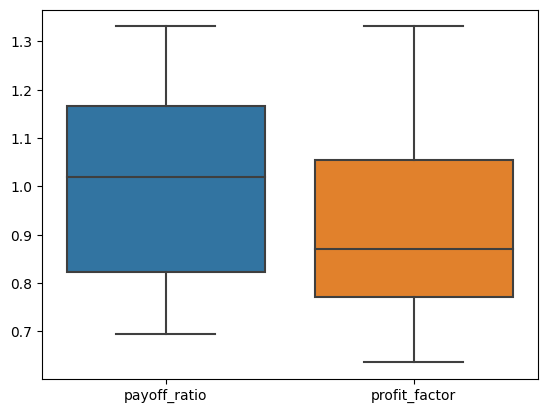

In [196]:
# 상위, 하위 5%의 값을 구합니다.
payoff_ratio_5per = trade_result.payoff_ratio.quantile(q=0.25)
payoff_ratio_95per = trade_result.payoff_ratio.quantile(q=0.75)
profit_factor_5per = trade_result.profit_factor.quantile(q=0.25)
profit_factor_95per = trade_result.profit_factor.quantile(q=0.75)

# 상위, 하위 5%를 제외한 값으로 데이터프레임을 필터링합니다.
trade_result_filtered = trade_result[(trade_result['payoff_ratio'] >= payoff_ratio_5per) & (trade_result['payoff_ratio'] <= payoff_ratio_95per) & 
                 (trade_result['profit_factor'] >= profit_factor_5per) & (trade_result['profit_factor'] <= profit_factor_95per)]

# payoff_ratio와 profit_factor에 대한 boxplot을 그립니다.
sns.boxplot(data=trade_result_filtered[['payoff_ratio', 'profit_factor']])

# 097950 CJ 제일제당 확인하기

In [18]:
test_start_day = '2021-01-01'
test_end_day = '2022-12-31'

### 벤치마크 누적 수익률 변화

In [19]:
stock_data = pd.DataFrame(fdr.DataReader('011790', test_start_day, test_end_day))
stock_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)
stock_data = stock_data.reset_index()

In [20]:
stock_data

,Date,Open,High,Low,Close,Volume
0,2021-01-04,95800.0,102500.0,94000.0,101500.0,1004073.0
1,2021-01-05,100500.0,104000.0,99100.0,102500.0,535864.0
2,2021-01-06,104000.0,107000.0,100500.0,102000.0,633921.0
3,2021-01-07,103000.0,105000.0,101000.0,102000.0,454619.0
4,2021-01-08,104500.0,110000.0,102000.0,106500.0,756952.0
...,...,...,...,...,...,...
489,2022-12-23,94900.0,95900.0,92200.0,92400.0,146808.0
490,2022-12-26,92400.0,93200.0,91400.0,92800.0,119402.0
491,2022-12-27,93700.0,94300.0,92300.0,92900.0,109614.0
492,2022-12-28,91500.0,91600.0,88800.0,89400.0,181192.0


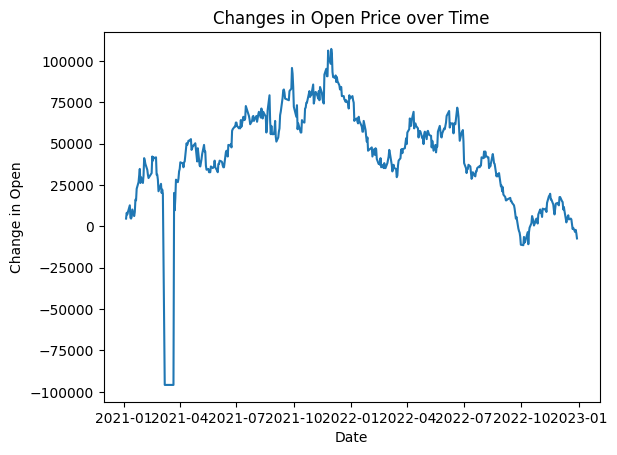

In [21]:
# 전일 대비 시가 변화 계산하기
stock_data['시가변화'] = stock_data['Open'] - stock_data['Open'].shift(1)

# 누적 수익 계산하기
stock_data['누적수익'] = stock_data['시가변화'].cumsum()

# 시계열 그래프 그리기
plt.plot(stock_data['Date'], stock_data['누적수익'])
plt.xlabel('Date')
plt.ylabel('Change in Open')
plt.title('Changes in Open Price over Time')
plt.show()

# 캔들 매매 누적 수익 계산하기

In [8]:
stock_trade = pd.read_csv("./meme/trade_8/086790_buy_sell.csv", encoding='euc-kr')
stock_trade = stock_trade.dropna(axis = 0)
stock_trade = stock_trade[['Date', 'Return Rate', 'Accumulated Return', 'Buy Price', 'Sell Price', 'Realized Return']]

In [9]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

In [10]:
stock_trade['Date'] = pd.to_datetime(stock_trade['Date'])

In [11]:
merge_df = pd.merge(stock_data, stock_trade[['Date', 'Return Rate', 'Accumulated Return', 'Buy Price', 'Sell Price', 'Realized Return']], on = 'Date', how = 'outer')

In [12]:
# merge_df['Realized Return'] = merge_df['Realized Return'].replace(0, pd.np.nan).ffill().fillna(0)

In [13]:
merge_df['캔들누적수익'] = merge_df['Realized Return'].cumsum()

In [14]:
merge_df.to_csv("wqeqweq.csv", encoding="euc-kr")

In [15]:
merge_df = pd.read_csv("wqeqweq.csv", encoding="euc-kr")

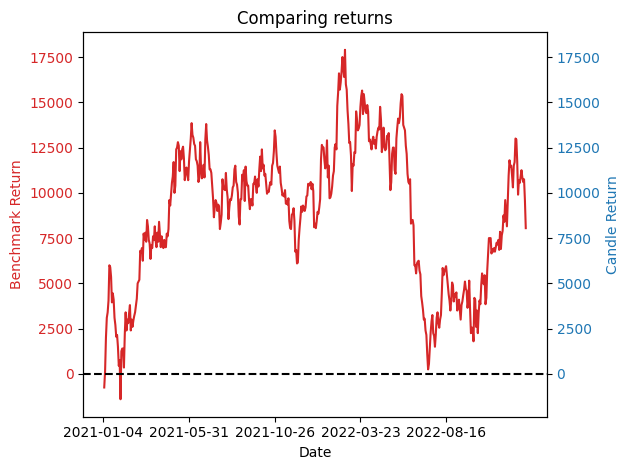

In [16]:
# x축으로 사용할 날짜 데이터
dates = merge_df['Date']

# y축으로 사용할 데이터
bench_return = merge_df['누적수익']
candle_return = merge_df['캔들누적수익']

# 그래프 생성
fig, ax1 = plt.subplots()

# Close 데이터 시각화
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Benchmark Return', color=color)
ax1.plot(dates, bench_return, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Accumulated Return 데이터 시각화
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Candle Return', color=color)
ax2.plot(dates, candle_return, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.axhline(y=0, color='black', linestyle='--')

# X축 레이블 일부분만 표시하기
n = 100  # 1/n 비율로 표시
plt.xticks(range(0, len(dates), n), dates[::n], rotation=45)

# ax1과 ax2의 Y축 범위 동일하게 설정하기
ax2.set_ylim(ax1.get_ylim())

# 그래프 출력
plt.title('Comparing returns')
fig.tight_layout()
plt.show()